## Introduction
The objective of the EDA stage is to thoroughly investigate and understand the dataset. We aim to establish how the review sentiment targets are related to the text content, and identify key words or phrases that differentiate between positive and negative sentiment classes in product reviews.

## Contents:
* Preparing the ground
    * Importing Libraries and Datasets
    * Data Check and Preprocessing
* Analysis
    * Example Comments
    * Original Dataset Size Check
    * Corpus Cleaning
    * First Word and Wordcount
    * Wordclouds: Most Common Words
    * BOW: Bag of Words
    * TF-IDF
    * Halfway Conclusion
* Feature Generation
    * Additional Features Generation
    * TF-IDF Feature Generation
    * Saving Metrics to File (.jpg)
* Training
    * Logistic Regression
    * Support Vector Classifier (SVC)
    * XGBoost Classifier (XGBClassifier)
* Conclusion

### Importing Libraries and Datasets

In [50]:
# pip install --upgrade scikit-learn

In [51]:
# pip install --upgrade --user numpy wordcloud matplotlib pillow

In [52]:
import pandas as pd
import numpy as np
import re
import os
import string
import pickle
import warnings
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import (
    ENGLISH_STOP_WORDS,
    CountVectorizer,
    TfidfVectorizer,
)
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from PIL import Image
from IPython.display import Image, display

RANDOM_STATE = 42
import nltk

nltk.download("vader_lexicon")
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 500)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Morea\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [53]:
# url='https://drive.google.com/file/d/1eEtlmdLUTZnyY34g9bL5D3XuWLzSEqBU/view?usp=sharing'
# path ='https://drive.google.com/uc?id=' + url.split('/')[-2]
# df = pd.read_csv(path)

# url="https://drive.google.com/file/d/1x2Tdn1UGhQ6x08yfchUykUJvid257vFY/view?usp=sharing"
# path ='https://drive.google.com/uc?id=' + url.split('/')[-2]
# df2 = pd.read_csv(path)

In [54]:
# Home PC
df = pd.read_csv(
    "D:/Programming/DB's/Positive_negative_reviews_classification/reviews.csv"
)
df2 = pd.read_csv(
    "D:/Programming/DB's/Positive_negative_reviews_classification/labels.csv"
)

# # work PC
# df = pd.read_csv("D:/Programming/db's/Positive_negative_reviews_classification_data/reviews.csv")
# df2 = pd.read_csv("D:/Programming/db's/Positive_negative_reviews_classification_data/labels.csv")

In [55]:
# Create a mapping dictionary
mapping = {"Positive": 1, "Negative": 0}

# Use the map function to replace values
df2.sentiment = df2.sentiment.map(mapping)

In [56]:
df.shape

(254, 2)

In [57]:
df2.shape

(254, 2)

### Data Check and Preprocessing

#### Duplicates

In [58]:
df.tail(5)

,id,text
249,189,"Thank you, this is beautiful and they loved it."
250,72,Thanks so much. They lookgreat!
251,107,"Emily, \n THANK YOU so much for the new “bric..."
252,271,"Jacqueline, \n I just received the replaceme..."
253,103,Order #(857)982-509708\nI just received my ord...


*  Dataset "reviews" has 254 samples, contain "id" and "text" column

In [59]:
print(df.id.tail(5))
print(df2.id.tail(5))

249    189
250     72
251    107
252    271
253    103
Name: id, dtype: int64
249    189
250     72
251    107
252    271
253    103
Name: id, dtype: int64


* IDs of both CSV files corresponds

In [60]:
df.isnull().sum()

id      0
text    0
dtype: int64

* no NULLs

In [61]:
duplicates = df[df["text"].duplicated(keep=False)]
print(duplicates)

      id                                               text
121  309  I just received my item and it is absolutely M...
177   12  I just received my item and it is absolutely M...


In [62]:
df.text.iloc[121]

'I just received my item and it is absolutely MF Amazing!!!!!! WOW.    \n\n Sent from my iPhone'

In [63]:
print(df2.sentiment.iloc[121])
print(df2.sentiment.iloc[177])

1
1


* we drop the duplicate

In [64]:
df.drop(121, axis=0, inplace=True)
df2.drop(121, axis=0, inplace=True)

In [65]:
df.tail(5)

,id,text
249,189,"Thank you, this is beautiful and they loved it."
250,72,Thanks so much. They lookgreat!
251,107,"Emily, \n THANK YOU so much for the new “bric..."
252,271,"Jacqueline, \n I just received the replaceme..."
253,103,Order #(857)982-509708\nI just received my ord...


* there are no duplicates in text now

## Analysis

### Example Comments

In [66]:
df.text.iloc[0]

'Hi Leah, I ordered this early to give to a co-worker for a Christmas gift. However, I am really impressed with they 3D item came out. I do plan to show it to another co-worker to see what she thinks about the outcome. Thank you reaching out and most of all it was such a quick turnaround.  \n  Great service.  Matthew Mason;\n\n Sent from Yahoo Mail on Android'

In [67]:
df.text.iloc[-1]

'Order #(857)982-509708\nI just received my order!  They are fantastic - even better than I expected.   I ordered 3 different items but only received 1 cleaning cloth.  Can you send me 2 more?  Thank you.  James Young'

In [68]:
df.text.iloc[50]

"Hello,I received my order today. thank-you!! my Daughter will love it!! I'm giving for Christmas gift. thank you again!  I will recommend to friends!!"

In [69]:
df.text.iloc[20]

"I received the Item a few days ago. I was verypleasantly surprised how beautiful the item was. The detail was excellent and the photo looked 3d. I received so many compliments on it. I did make a  huge mistake on it. I put a date of 1974 when it should have been 1973. I can't believe I did that. It was  totally my fault. That takes away something from it for me. There's nothing I can do about it now.  \n  Thank You for everything your and yourteam did. You do excellent work and it's a memory that will last  a lifetime! I will let everyone who I show it to see how your company is the best. Thanks again, Tammy Logan;"

In [70]:
df.text.iloc[70]

'I ordered 5 key chains, I am not happy with.you can’t see the pictures in them .I want to return them.'

* ok, keychains

In [71]:
df.text.iloc[90]

'Hi there!\n\nJust wanted to let you know we did in fact receive your product on time and in beautiful condition.  It is amaaazingly beautifully well done. Thank you so much.\n\nBest Regards,\n\nMichaela & Erik Velasquez'

In [72]:
df.text.iloc[110]

'I just would like to thank you from the bottom of my heart it came out beautiful it really looks like my dad now I can see and be with him everyday thank you very much I will recommend to all my friends and family again thank you\n\n\n  Sent from AOL Mobile Mail\nGet the new AOL app: mail.mobile.aol.com'

* should remove "Sent from...."

In [73]:
df.text.iloc[130]

"Adam, \n\n The towers we gave at Christmas gifts or warmly and passionately received. They loved them as my wife did hers. We wrote a wonderful review but we have not seen it on your website. We would be most happy to do it again if you would send us a link or instructions. Thank you again! \n\n Brendan \n\n Sent from my iPhone\n\nBrendan Lillard \n\n Arthur J. Gallagher & Co.\n\n12 E Central | Port Jefferybury, LA 74354\n\nMobile: 992-584-3185\n\nalexandria17@yahoo.com\n\njames81@yahoo.com\n\n \n\nThe intent of this analysis is to provide you with general information regarding the status of, and/or potential concerns related to, your current employee benefits issue. It does not necessarily fully address all your specific issues. It should not be construed as, nor is it intended to provide, legal advice. Questions regarding specific issues should be addressed by the client's general counsel or an attorney who specializes in this practice area. \n\n \n\nThis e-mail and any files transm

* looks like the shop is selling some custom artwork like statuette and hand-made keychains...

In [74]:
df.text.iloc[150]

'I just opened the medium heart I ordered\nOrder # (673)305-513556\nI had requested the date to be small print and it bolds out, it’s too large \nI’m not happy with my purchase.\nMr. Austin Ellis \n8335955989\nryan64@hotmail.com'

In [75]:
df.text.iloc[169]

'Hi Kimberly, \n  \n I just picked it up from the front desk today.  \n I was going to send you an email before the day was done, & let you know how Wonderful it looks!! \n  \n We appreciate your time, & energy on this creation. Look forward to doing business with you again. \n  \n We are so happy with how it turned out!! \n  \n Thank you, & your team so much! \n  \n Respectfully, \n Joseph Allen \n  \n  \n \nJoseph Allen\n\nPsychometrist, TMA- Mental Health and Wellness \n \nKaiser Permanente\n\n\nOffice: (763)534-5911 \n  \n  \n \nJoseph Allen\n\nPsychometrist, TMA- Mental Health and Wellness \n \nKaiser Permanente\n\n\nOffice: (763)534-5911 \n  \n \n NOTICE TO RECIPIENT:\nIf you are not the intended recipient of this e-mail, you are prohibited from sharing, copying, or otherwise using or disclosing its contents.\nIf you have received this e-mail in error, please notify the sender immediately by reply e-mail and permanently delete this e-mail and any attachments without reading, forw

In [76]:
# Check if any sample contains "NOTICE TO RECIPIENT"
contains_notice = df["text"].str.contains("NOTICE TO RECIPIENT")

# Filter and print samples containing the notice
samples_with_notice = df[contains_notice]
print(samples_with_notice.text)

170    Hi Kimberly, \n  \n I just picked it up from t...
Name: text, dtype: object


* looks like it's such caution "NOTICE TO RECIPIENT" happens once 

In [77]:
df.text.iloc[190]

'Thank you so much for your service has she enjoyed it so much it was more than we expected and if I have any other gifts I want to buy for myself or my family I would definitely recommend you guys you guys are awesome'

In [78]:
df.text.iloc[209]

"Ann Thank you. I love my product. There is a blemish on it where it looks like a piece of tape that illuminates when put on the base. Its noticable but it may be because of how the cats whiskers had to be done. Wasn't expecting that in such a fine product and at what I paid but it's no big deal I suppose. Just looks odd. Very happy otherwise.  \n  Thomas"

* cat and whiskers well made

In [79]:
df.text.iloc[252]

'Order #(857)982-509708\nI just received my order!  They are fantastic - even better than I expected.   I ordered 3 different items but only received 1 cleaning cloth.  Can you send me 2 more?  Thank you.  James Young'

* maybe need to remove order number and leave only word "order" though?

In [80]:
df.text.iloc[123]

'Hi Brooke, \n  I absolutely love it. It’s for my best friends 60th birthday. I will giving you her on September 14. I want to take a photo with the cube and then submit review. Hope you don’t mind. She’s gonna love it as much as I do.   \n  Stay well.  \n  Dorothy  \n  \n\n Sent from my iPhone'

In [81]:
df.text.iloc[97]

"I know this e-mail address is for support stuff but I just wanted to reach out and say how amazing my order turned out! The picture I used was of my brother who passed away in September and I ordered this for my mom. It is incredible and she is going to love it (and cry a lot.) Thank you so much for this wonderful gift, I can't wait to place my next order for a larger size! \n  Thank you again,  \n  \n  James Simmons"

* the store sells photo frames with custom photos

### Original Dataset Size Check

In [82]:
df.sort_values("id", ascending=False)

,id,text
230,319,Im am beyond devastated ups tracking said they...
52,318,I’m so impressed with your work! I just wish I...
178,317,"Hello,\n \n\n \n This has arrived and it’s bea..."
82,316,Awww thank you all for the delivery updates. I...
223,315,Thank you I loved it my one concern was my mes...
159,314,I'm very happy with the item memory that I had...
206,312,I'm very disappointed in the size and of the h...
225,308,"To ALL this may concern, I am one SATISFIED cu..."
111,307,"\n Message \n Order #245371902556 recibed, sup..."
106,305,Hi Bruce: \n Thank you for remaking the item ...


In [83]:
# Create a range of expected IDs (e.g., from 1 to max_id)
max_id = df["id"].max()  # Assuming 'ID' is a numeric column
expected_ids = set(range(1, max_id + 1))

# Convert the column of unique IDs to a set
actual_ids = set(df["id"])

# Find the missing IDs
missing_ids = expected_ids - actual_ids

# Display the missing IDs as a list
missing_id_list = list(missing_ids)
print("Missing IDs:", sorted(missing_id_list, reverse=1))
print("Number of missing IDs:", len(missing_id_list))

Missing IDs: [313, 311, 310, 309, 306, 301, 300, 291, 290, 282, 279, 278, 273, 268, 262, 258, 252, 249, 247, 242, 234, 231, 230, 228, 221, 198, 190, 186, 171, 162, 160, 159, 158, 157, 153, 144, 127, 125, 123, 98, 97, 96, 94, 90, 87, 83, 81, 79, 77, 71, 70, 66, 58, 54, 52, 50, 46, 45, 41, 21, 17, 16, 13, 11, 9, 2]
Number of missing IDs: 66


66(missed IDs)+253(present IDs)=319 (total)

or

319 * 0.8 = 255 or ≈ 253 (present IDs)
* Dataset we were given represents 80% of the entire dataset owned by the customer as was stated 


In [84]:
print(
    f"Number of Positives: {df2.sentiment.value_counts()[0]} or {100*round(df2.sentiment.value_counts()[0]/len(df2), 2)}%"
)
print(
    f"Number of Negatives: {df2.sentiment.value_counts()[1]} or {100*round(df2.sentiment.value_counts()[1]/len(df2), 2)}%"
)

Number of Positives: 102 or 40.0%
Number of Negatives: 151 or 60.0%


* most of ML algorithms can handle this level of class imbalance without significant issues.

In [85]:
# Split the data into training and testing sets (80% train, 20% test)
train_X, test_X, train_y, test_y = train_test_split(
    df, df2["sentiment"], test_size=0.2, random_state=RANDOM_STATE
)

#### Add features (a few)

* need to run it before we lose such details in preprocessing

### Corpus Cleaning

In [86]:
def clean_text(text):
    text = text.lower()

    # Define the pattern to match "Sent from..." and everything after it
    text = re.sub(r"Sent from.*$", "", text)

    # Define the pattern to match "Order" followed by numbers and spaces Use re.sub() to replace the pattern with "order"
    text = re.sub(r"Order\s*\(#\d+\)", "order number", text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub("\W", " ", text)  # != a-z, A-Z, and 0-9
    text = re.sub(
        "\s+", " ", text
    )  # s(spaces)== \t \n \r (return carret on the beginning)

    text = re.sub("<.*?>", " ", text)
    text = text.translate(str.maketrans(" ", " ", string.punctuation))

    # Keep ! and ? symbols
    text = re.sub("[^a-zA-Z!?]", " ", text)
    text = re.sub("\n", " ", text)
    text = text.strip(" ")
    return text

In [87]:
df["text"] = df["text"].apply(clean_text)

* text cleaned

### First Word and Wordcount

In [88]:
# Extract the first word from each comment and create a new column
df["first_word"] = df["text"].str.split().str[0]

# Sort the DataFrame based on the 'first_word' column
df_sorted = df.sort_values(by="first_word")

# Count the occurrences of each unique first word
word_counts = df_sorted["first_word"].value_counts()

# Display the sorted DataFrame
print("Sorted DataFrame:")
print(df_sorted)

Sorted DataFrame:
      id                                               text  first_word
131  240  adam the towers we gave at christmas gifts or ...        adam
154  179  afternoon mr melinda first let me say i love t...   afternoon
76    82  alan the gift was for my wife and she loved it...        alan
96   302  alexandria foster i received the heart i order...  alexandria
210  191  ann thank you i love my product there is a ble...         ann
199  217  appreciate your response but because the produ...  appreciate
82   316  awww thank you all for the delivery updates i ...        awww
220   89  bradley that s awesome thank you so much i apo...     bradley
233   59  dear alexandra thank for your quick and warm r...        dear
92    80  emily i just want to say that i took your word...       emily
251  107  emily thank you so much for the new brick item...       emily
231  188  everything is good beautiful piece great job m...  everything
25   184  first and foremost i absolutely love

In [89]:
# First word counts
print("First word Counts:")
word_counts

First word Counts:


i             69
hello         24
hi            21
thank         14
message       10
the            9
good           9
my             8
yes            6
to             5
just           5
we             4
it             4
received       3
order          3
how            2
ordered        2
sent           2
kelly          2
you            2
hey            2
thanks         2
what           2
well           2
emily          2
this           2
susan          1
review         1
support        1
sir            1
recibe         1
very           1
product        1
warry          1
sirs           1
so             1
noah           1
adam           1
mr             1
greetings      1
alan           1
alexandria     1
ann            1
appreciate     1
awww           1
bradley        1
dear           1
everything     1
first          1
great          1
have           1
morning        1
if             1
im             1
img            1
in             1
jacqueline     1
james          1
kind          

* most of comments begins with words like: "I"(most cases), "Hello"\"Hi", "Thank (you)"

These introductory words can provide context to the comment's tone and purpose. For instance, comments that start with "I" might focus on the commenter's own thoughts, while comments that start with "Thank you" are likely expressing gratitude. But still, to understand data we need go deeper.

### Wordclouds: Most Common Words 

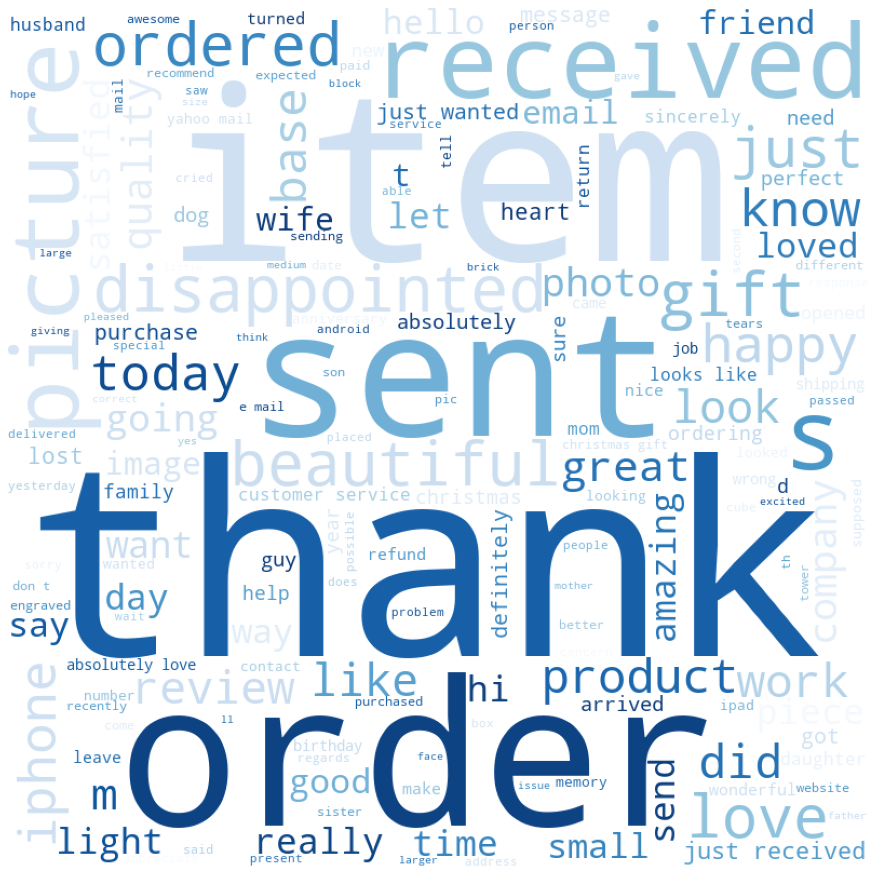

In [90]:
# Python program to generate WordCloud
comment_words = ""
stopwords = set(ENGLISH_STOP_WORDS)

# iterate through the csv file
for val in df.text:
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize=(12, 12), facecolor=None)
plt.axis("off")
plt.tight_layout(pad=0)

plt.imshow(wordcloud.recolor(colormap="Blues", random_state=111), alpha=0.98)

# Save the WordCloud as a JPG file in the same folder
output_filename = "wordcloud.jpg"
output_path = os.path.join(os.getcwd(), output_filename)
plt.savefig(output_path, format="jpg")

* the wordcloud shows that the dataset is tematic and mostly consist of customer comments.

the main message is - "order received, thank (or not)"

### BOW: Bag of Words

In [91]:
# Initialize CountVectorizer with optional parameters (you can adjust them as needed)
count_vectorizer = CountVectorizer(stop_words=list(ENGLISH_STOP_WORDS))

# Fit and transform the text data to create the BoW representation
bow_matrix = count_vectorizer.fit_transform(df.text)

# Get feature names (words)
bow_feature_names = count_vectorizer.get_feature_names_out()

# Create a DataFrame to store BoW results
df_bow = pd.DataFrame(bow_matrix.toarray(), columns=bow_feature_names)

# Calculate word frequencies
word_frequencies = df_bow.sum().sort_values(ascending=False)

# Display the top N keywords based on word frequencies (adjust N as needed)
top_keywords_bow = word_frequencies.head(20)
print("Top Keywords (BoW):")
print(top_keywords_bow)

Top Keywords (BoW):
thank           157
item            143
order           104
received         94
sent             81
just             81
disappointed     66
gift             57
beautiful        56
love             54
ordered          53
picture          53
like             47
iphone           46
thanks           45
happy            41
did              40
know             39
today            38
base             37
dtype: int64


### TF-IDF

In [92]:
# Initialize TfidfVectorizer with optional parameters (you can adjust them as needed)
tfidf_vectorizer = TfidfVectorizer(stop_words=list(ENGLISH_STOP_WORDS))

# Fit and transform the text data to create the TF-IDF representation
tfidf_matrix = tfidf_vectorizer.fit_transform(df.text)

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store TF-IDF results
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Calculate TF-IDF scores
tfidf_scores = df_tfidf.mean().sort_values(ascending=False)

# Display the top N keywords based on TF-IDF scores (adjust N as needed)
top_keywords_tfidf = tfidf_scores.head(20)
print("\nTop Keywords (TF-IDF):")
print(top_keywords_tfidf)
type(top_keywords_tfidf)


Top Keywords (TF-IDF):
thank           0.057791
item            0.048705
order           0.040628
received        0.040266
sent            0.038786
beautiful       0.038073
just            0.036558
love            0.031706
iphone          0.028826
disappointed    0.027921
ordered         0.027545
thanks          0.026396
great           0.024782
gift            0.024753
picture         0.024234
today           0.023540
happy           0.021568
review          0.020837
base            0.020830
like            0.020805
dtype: float64


pandas.core.series.Series

### Halfway Conclusion

    Keyword Significance: The keywords with the highest TF-IDF and BOW scores are considered significant within the dataset. In your list, "thank," "item," "order," "received," "sent," and "beautiful" have relatively high TF-IDF and BOW scores, suggesting that they are important terms in the reviews.

    Positive Sentiment: Some of the keywords with high TF-IDF and BOW scores, such as "thank," "beautiful," "love," "great," "happy," and "gift," suggest positive sentiment. These words are likely to appear frequently in positive reviews.

    Negative Sentiment: While most of the top keywords appear to indicate positive sentiment, the presence of "disappointed" suggests negative sentiment. It is possible that "disappointed" is a strong indicator of negative reviews.

    Order-Related Terms: Keywords like "item," "order," "received," "sent," "ordered," and "thanks" are related to the process of ordering and receiving items. These terms may indicate that the dataset contains reviews related to online shopping or purchases.

    Product-Specific Terms: Terms like "picture" and "base" are specific to certain products or items. The presence of this terms may indicate that the dataset contains reviews for a variety of products, including items with pictures on some "base".

    Contextual Insights: The presence of certain terms can provide context for the dataset. For example, "today" and "review" may indicate that some reviews were written on the day of receiving the product or are reviews themselves.

## Feature Generation

In [93]:
# Split the data into training and testing sets (80% train, 20% test)
train_X, test_X, train_y, test_y = train_test_split(
    df[["text"]], df2["sentiment"], test_size=0.2, random_state=RANDOM_STATE
)

### Additional features generation

In [94]:
def feature_generator(df):
    """
    Generate and append various text-based features to a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing a 'text' column.

    Returns:
        np.ndarray: An array of scaled features (including original and derived features).

    This function calculates and appends the following features to the input DataFrame:
    - Count of punctuations in each text
    - Count of words in uppercase in each text
    - Count of words in title case in each text
    - Sentiment scores (negative, neutral, positive, compound) for each text
    - Word count in each text
    - Count of unique words in each text
    - Count of letters in each text
    - Number of stopwords in each text
    - Mean word length in each text
    - Word count percent (unique words) in each text
    - Punctuation percent in each text

    The function then scales these features and returns them as an array.

    Note: The 'text' column in the input DataFrame will be modified to include cleaned text.
    """
    # punctuation count
    df.loc[:, "count_punctuations"] = df["text"].apply(
        lambda x: len([c for c in str(x) if c in string.punctuation])
    )  # including "I'll" as punctuation

    # upper case words count
    df.loc[:, "count_words_upper"] = df["text"].apply(
        lambda x: len([w for w in str(x).split() if w.isupper()])
    )

    # title case words count
    df.loc[:, "count_words_title"] = df["text"].apply(
        lambda x: len([w for w in str(x).split() if w.istitle()])
    )

    df["text"] = df["text"].apply(clean_text)
    sentiment = SentimentIntensityAnalyzer()

    # Initialize empty lists for each sentiment score
    neg_scores = []
    neu_scores = []
    pos_scores = []
    compound_scores = []

    # Loop through the sentences and calculate sentiment scores
    for sentence in df["text"]:
        ss = sentiment.polarity_scores(sentence)
        neg_scores.append(ss["neg"])
        neu_scores.append(ss["neu"])
        pos_scores.append(ss["pos"])
        compound_scores.append(ss["compound"])

    # Add sentiment scores as new columns to the DataFrame
    df["negative"] = neg_scores
    df["neutral"] = neu_scores
    df["positive"] = pos_scores
    df["compound"] = compound_scores
    # Word count in each comment:
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))

    # Unique word count
    df.loc[:, "count_unique_word"] = df["text"].apply(
        lambda x: len(set(str(x).split()))
    )

    # Letter count
    df.loc[:, "count_letters"] = df["text"].apply(lambda x: len(str(x)))

    # Number of stopwords
    df.loc[:, "count_stopwords"] = df["text"].apply(
        lambda x: len([w for w in str(x).lower().split() if w in ENGLISH_STOP_WORDS])
    )

    # Average length of the words
    df.loc[:, "mean_word_len"] = df["text"].apply(
        lambda x: round(np.mean([len(w) for w in str(x).split()]), 2)
    )

    # Derived features

    # Word count percent in each comment:
    df.loc[:, "word_unique_percent"] = (
        df.loc[:, "count_unique_word"] * 100 / df["word_count"]
    )
    # Punct percent in each comment:
    df.loc[:, "punct_percent"] = (
        df.loc[:, "count_punctuations"] * 100 / df["word_count"]
    )

    # Scale features
    scaled_features = StandardScaler().fit_transform(df.drop(columns=["text"]))
    # ↑↑↑ we need to scale them before we stack them with tf-idf features (which we shouldn't scale at all).

    return scaled_features

### TF-IDF Feature Generation

In [95]:
def tfidf(X, max_features=50, features: str = "all"):
    """
    Generate TF-IDF (Term Frequency-Inverse Document Frequency) features and optionally stack them with other features.

    Args:
        X (pd.DataFrame): The input DataFrame containing a 'text' column.
        max_features (int): The maximum number of TF-IDF features to generate.
        features (str): Specifies which features to return.
            - 'all': Returns all features (scaled and TF-IDF).
            - 'tfidf': Returns only TF-IDF features.

    Returns:
        np.ndarray: An array of selected features based on the 'features' parameter.

    This function generates TF-IDF features based on the text content in the 'text' column of the input DataFrame (X).
    The generated TF-IDF features can be stacked with other features (scaled features) or returned separately based on the 'features' parameter.

    Note: The 'text' column in the input DataFrame will be used for TF-IDF feature extraction.
    """
    scaled_features = feature_generator(X)

    # Inin vectorizer
    tf_idf = TfidfVectorizer(
        ngram_range=(1, 1),
        max_features=max_features,
    )

    # Create TF-IDF features
    tfidf_features = tf_idf.fit_transform(X.text).toarray()

    # Stack them vertically
    stacked_array = np.hstack((scaled_features, tfidf_features))
    if features == "tfidf":
        out = tfidf_features
    elif features == "all":
        out = stacked_array
    return out

### Saving Metrics to File (.jpg)

In [96]:
def metrics(text, report, conf_matrix, auc, minutes, seconds, filename=None):
    """
    Generate classification metrics visualization and optionally save it as an image.

    Args:
        text (str): A text description or title for the metrics.
        report (str): The classification report.
        conf_matrix (numpy.ndarray): The confusion matrix.
        auc (float): The area under the ROC curve (AUC) score.
        minutes (int): The elapsed time in minutes.
        seconds (float): The elapsed time in seconds (fractions).
        filename (str, optional): The filename to save the visualization as an image. If not provided, the image will be displayed but not saved.

    Returns:
        None or IPython.display.Image: If a filename is provided, None is returned. Otherwise, the metrics visualization is displayed as an Image in the Jupyter Notebook.

    This function generates a classification metrics visualization including a classification report, confusion matrix, AUC score, and elapsed time.
    The visualization can be optionally saved as an image with the specified filename.
    """
    output_text = (
        f"{text}\n\n"
        "Classification Report:\n\n" + report + "\n\n"
        "Confusion Matrix:\n" + str(conf_matrix) + "\n\n"
        "AUC: "
        + str(int(auc * 100) / 100.0)
        + "\n\nElapsed time:\n"
        + f"{minutes} minutes\n{round(seconds, 3)} seconds"
    )

    # Create a fixed-size plot with the output text
    plt.figure(figsize=(8, 6))  # Specify the desired width and height in inches
    plt.text(
        0.9, 0.5, output_text, fontsize=12, ha="right", va="center", wrap=True
    )  # Adjust x-coordinate (0.9) for right alignment
    plt.axis("off")

    if filename:
        # Create a "metrics_pics" folder if it doesn't exist
        metrics_folder = "metrics_pics"
        if not os.path.exists(metrics_folder):
            os.makedirs(metrics_folder)

        # Save the plot as an image in the "metrics_pics" folder with the specified filename
        output_image_path = os.path.join(metrics_folder, filename)
        plt.savefig(output_image_path, bbox_inches="tight", pad_inches=0, dpi=300)
        plt.close()

        # Display the image in the Jupyter Notebook
        return display(Image(filename=output_image_path, width=400))

    # If no filename is specified, display the image without saving it
    return display(plt.gcf())

## Training

In [97]:
def train_and_evaluate_model(
    model_type,
    hyperparameters,
    train_X,
    train_y,
    test_X,
    test_y,
    max_features=50,
    features="all",
):
    """
    Train and evaluate a machine learning model.

    Parameters:
    - model_type (str): The type of the model to train ('logisticregression', 'svc', 'xgbclassifier').
    - hyperparameters (dict): Hyperparameters for model tuning.
    - train_X (array-like): Training features.
    - train_y (array-like): Training labels.
    - test_X (array-like): Test features.
    - test_y (array-like): Test labels.
    - max_features (int): Maximum number of features for TF-IDF vectorization (default: 50).
    - features (str): Type of features to use ('all' or 'tfidf').

    Returns:
    - best_model: The best trained model.
    """
    # transform text to numeric features
    train_X = tfidf(train_X, max_features=max_features, features=features)
    test_X = tfidf(test_X, max_features=max_features, features=features)

    # Create a "models" folder if it doesn't exist
    models_folder = "models"
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    # Start time
    start = datetime.now()

    # Define the model based on the given model type
    if model_type == "logisticregression":
        model = LogisticRegression(random_state=42, max_iter=50)
    elif model_type == "svc":
        model = SVC(probability=True, random_state=42)
    elif model_type == "xgbclassifier":
        model = XGBClassifier(random_state=42)

    # Create a pipeline with feature normalization and the chosen model
    pipeline = make_pipeline(StandardScaler(with_mean=False, with_std=False), model)

    # RandomizedSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=hyperparameters, scoring="roc_auc", cv=3
    )

    grid_search.fit(train_X, train_y)

    best_pipeline = grid_search.best_estimator_
    best_model = best_pipeline.named_steps[model_type]
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # End time
    end = datetime.now()

    # Calculate elapsed time
    elapsed_time = end - start

    # Extract minutes and seconds
    minutes, seconds = divmod(elapsed_time.total_seconds(), 60)

    # Specify the model name
    model_name = f"{model_type}"

    # Save the best model as a pickle file
    model_filename = os.path.join(models_folder, f"{model_name}_model.pkl")
    with open(model_filename, "wb") as model_file:
        pickle.dump(best_model, model_file)

    # Predict train dataset
    pred_y = best_pipeline.predict(train_X)

    # Calculate classification report, confusion matrix, AUC for train dataset
    report = classification_report(train_y, pred_y)
    conf_matrix = confusion_matrix(train_y, pred_y)
    auc = roc_auc_score(train_y, pred_y)

    # Train metrics to jpg
    metrics(
        text=f"Train set: {model_name} with TF-IDF + Additional features",
        report=report,
        conf_matrix=conf_matrix,
        auc=auc,
        minutes=minutes,
        seconds=seconds,
        filename=f"{model_name}_train_metrics.jpg",
    )

    # Predict test dataset
    pred_y = best_pipeline.predict(test_X)

    # Calculate classification report, confusion matrix, AUC for test dataset
    report = classification_report(test_y, pred_y)
    conf_matrix = confusion_matrix(test_y, pred_y)
    auc = roc_auc_score(test_y, pred_y)

    # Test metrics to jpg
    metrics(
        text=f"Test set: {model_name} with TF-IDF + Additional features",
        report=report,
        conf_matrix=conf_matrix,
        auc=auc,
        minutes=minutes,
        seconds=seconds,
        filename=f"{model_name}_test_metrics.jpg",
    )

    return best_model

### Logistic Regression

### Support Vector Classifier (SVC)

### XGBoost Classifier (XGBClassifier)

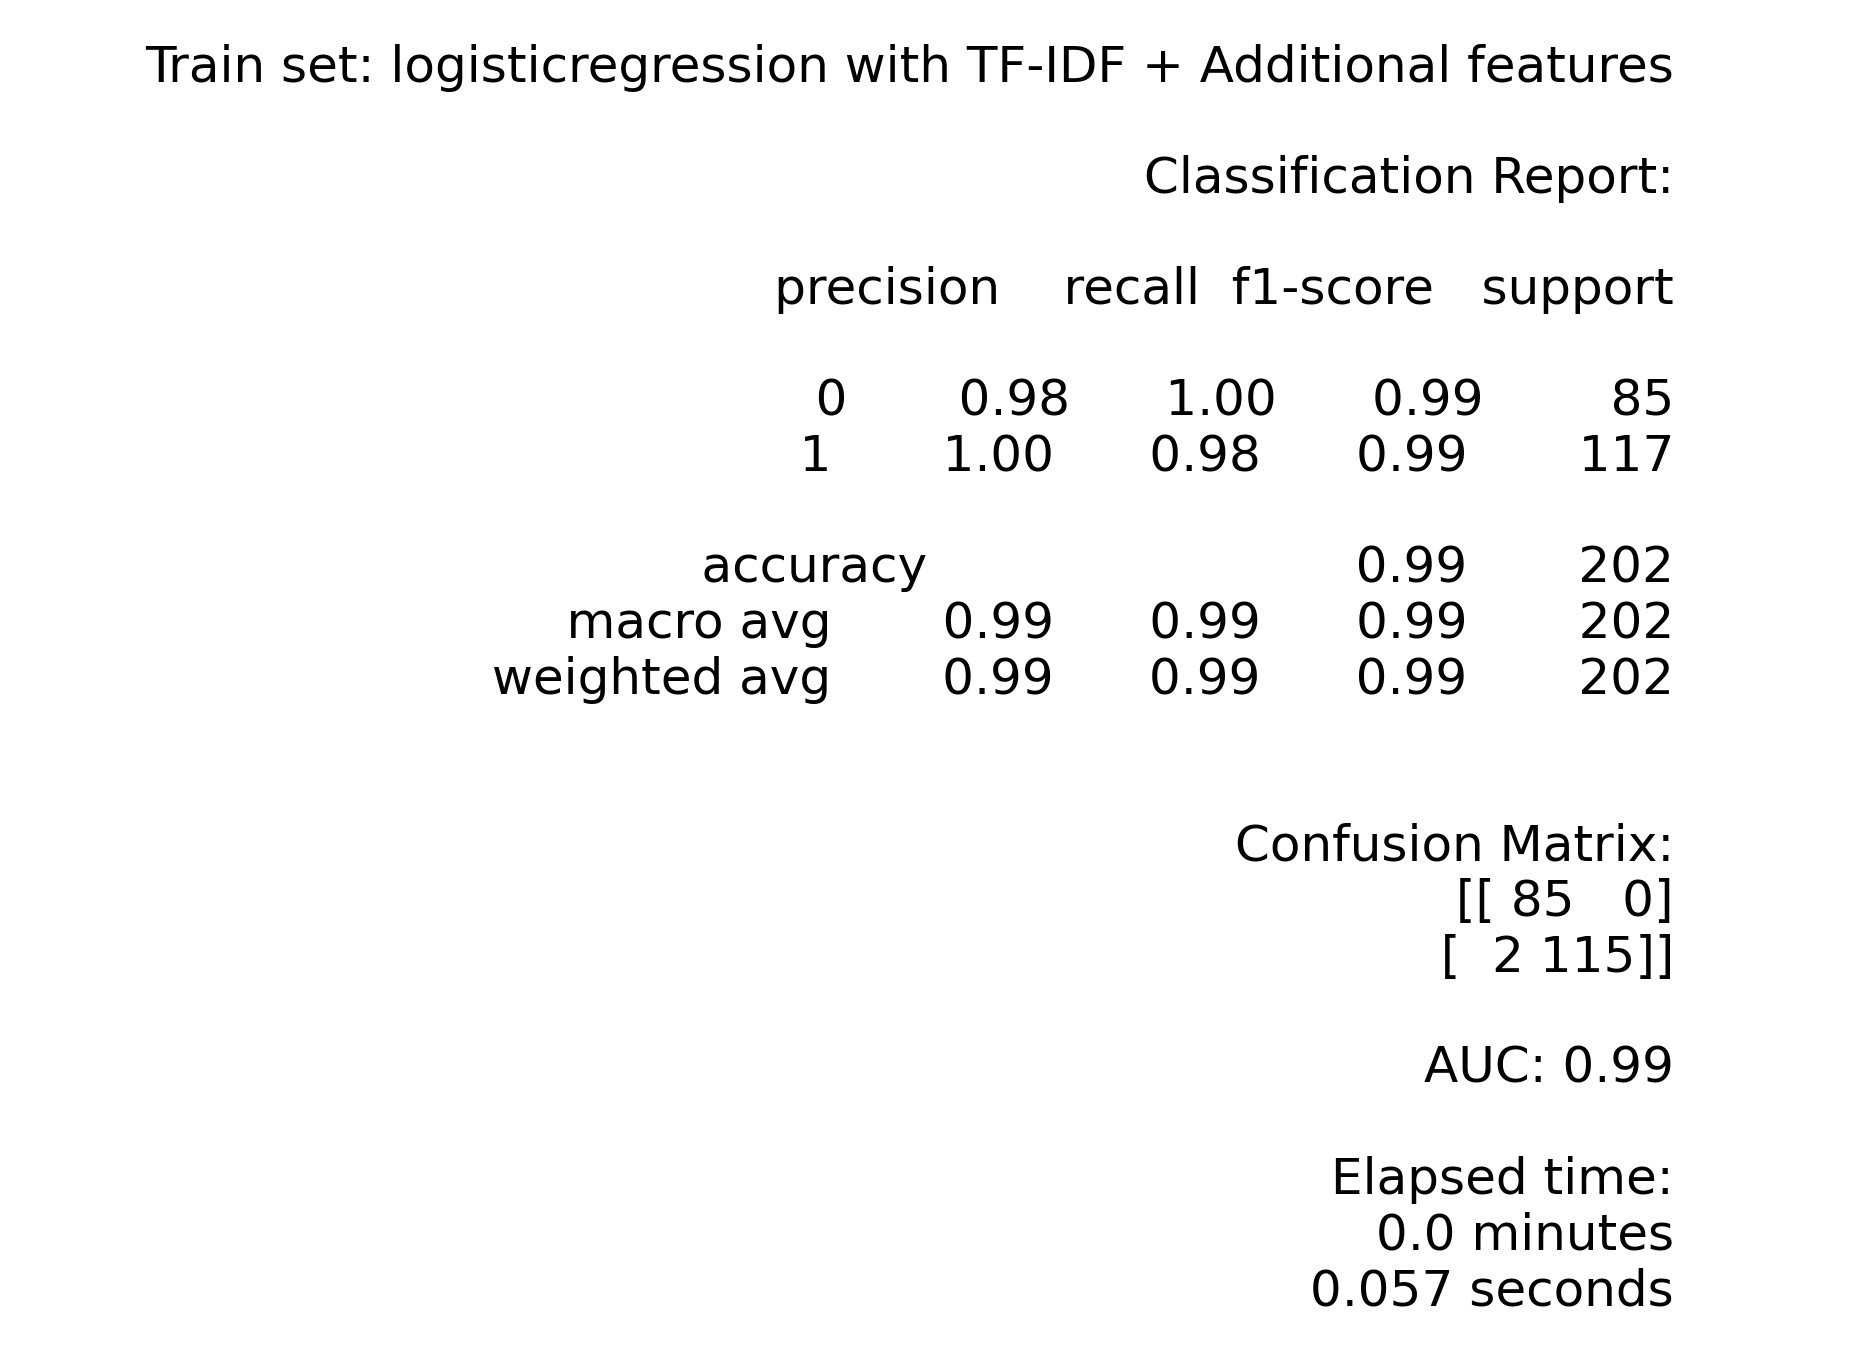

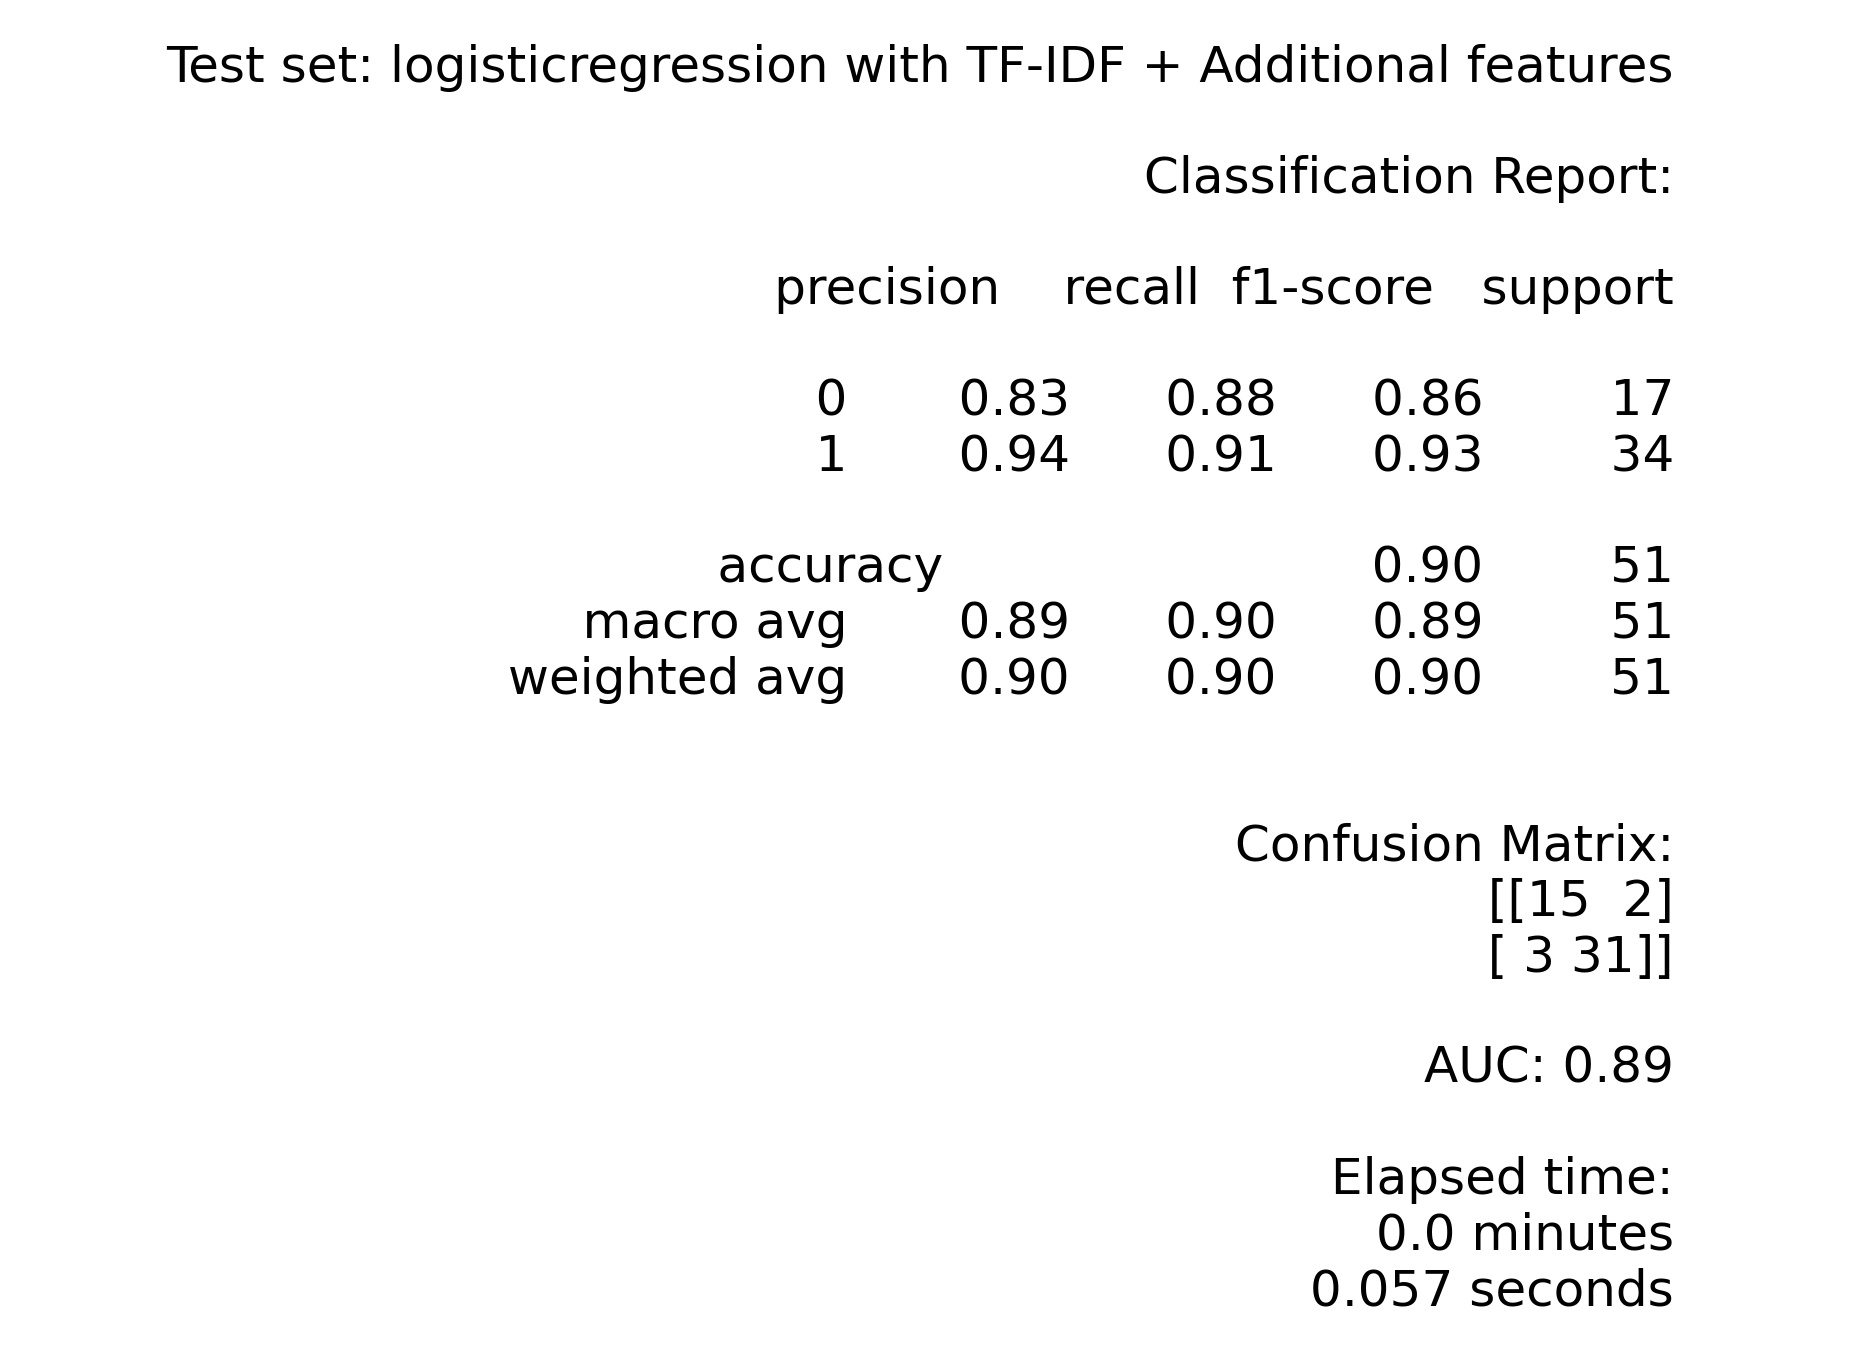

NEXT ARCHITECTURE


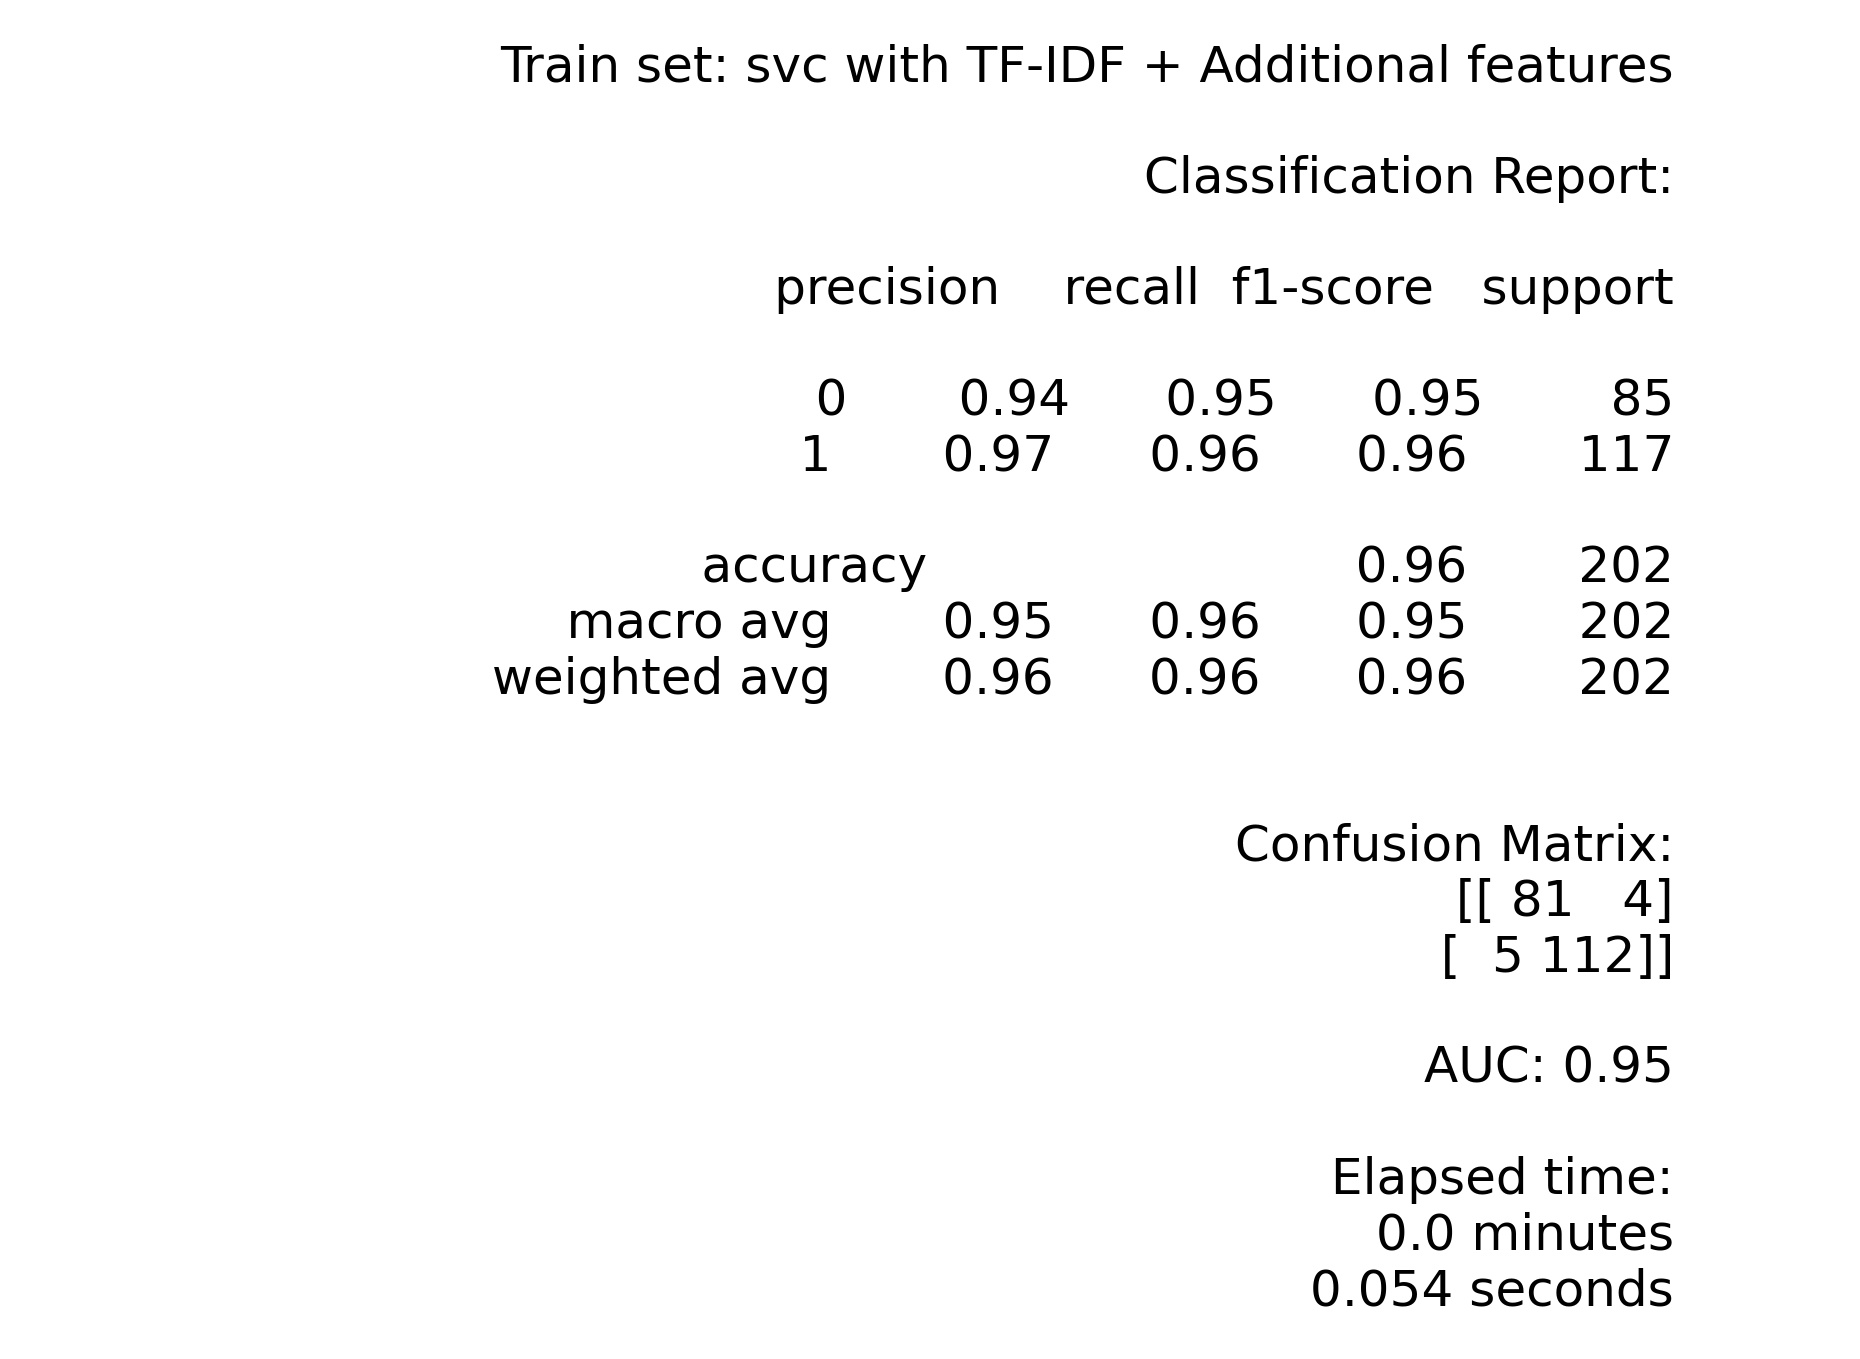

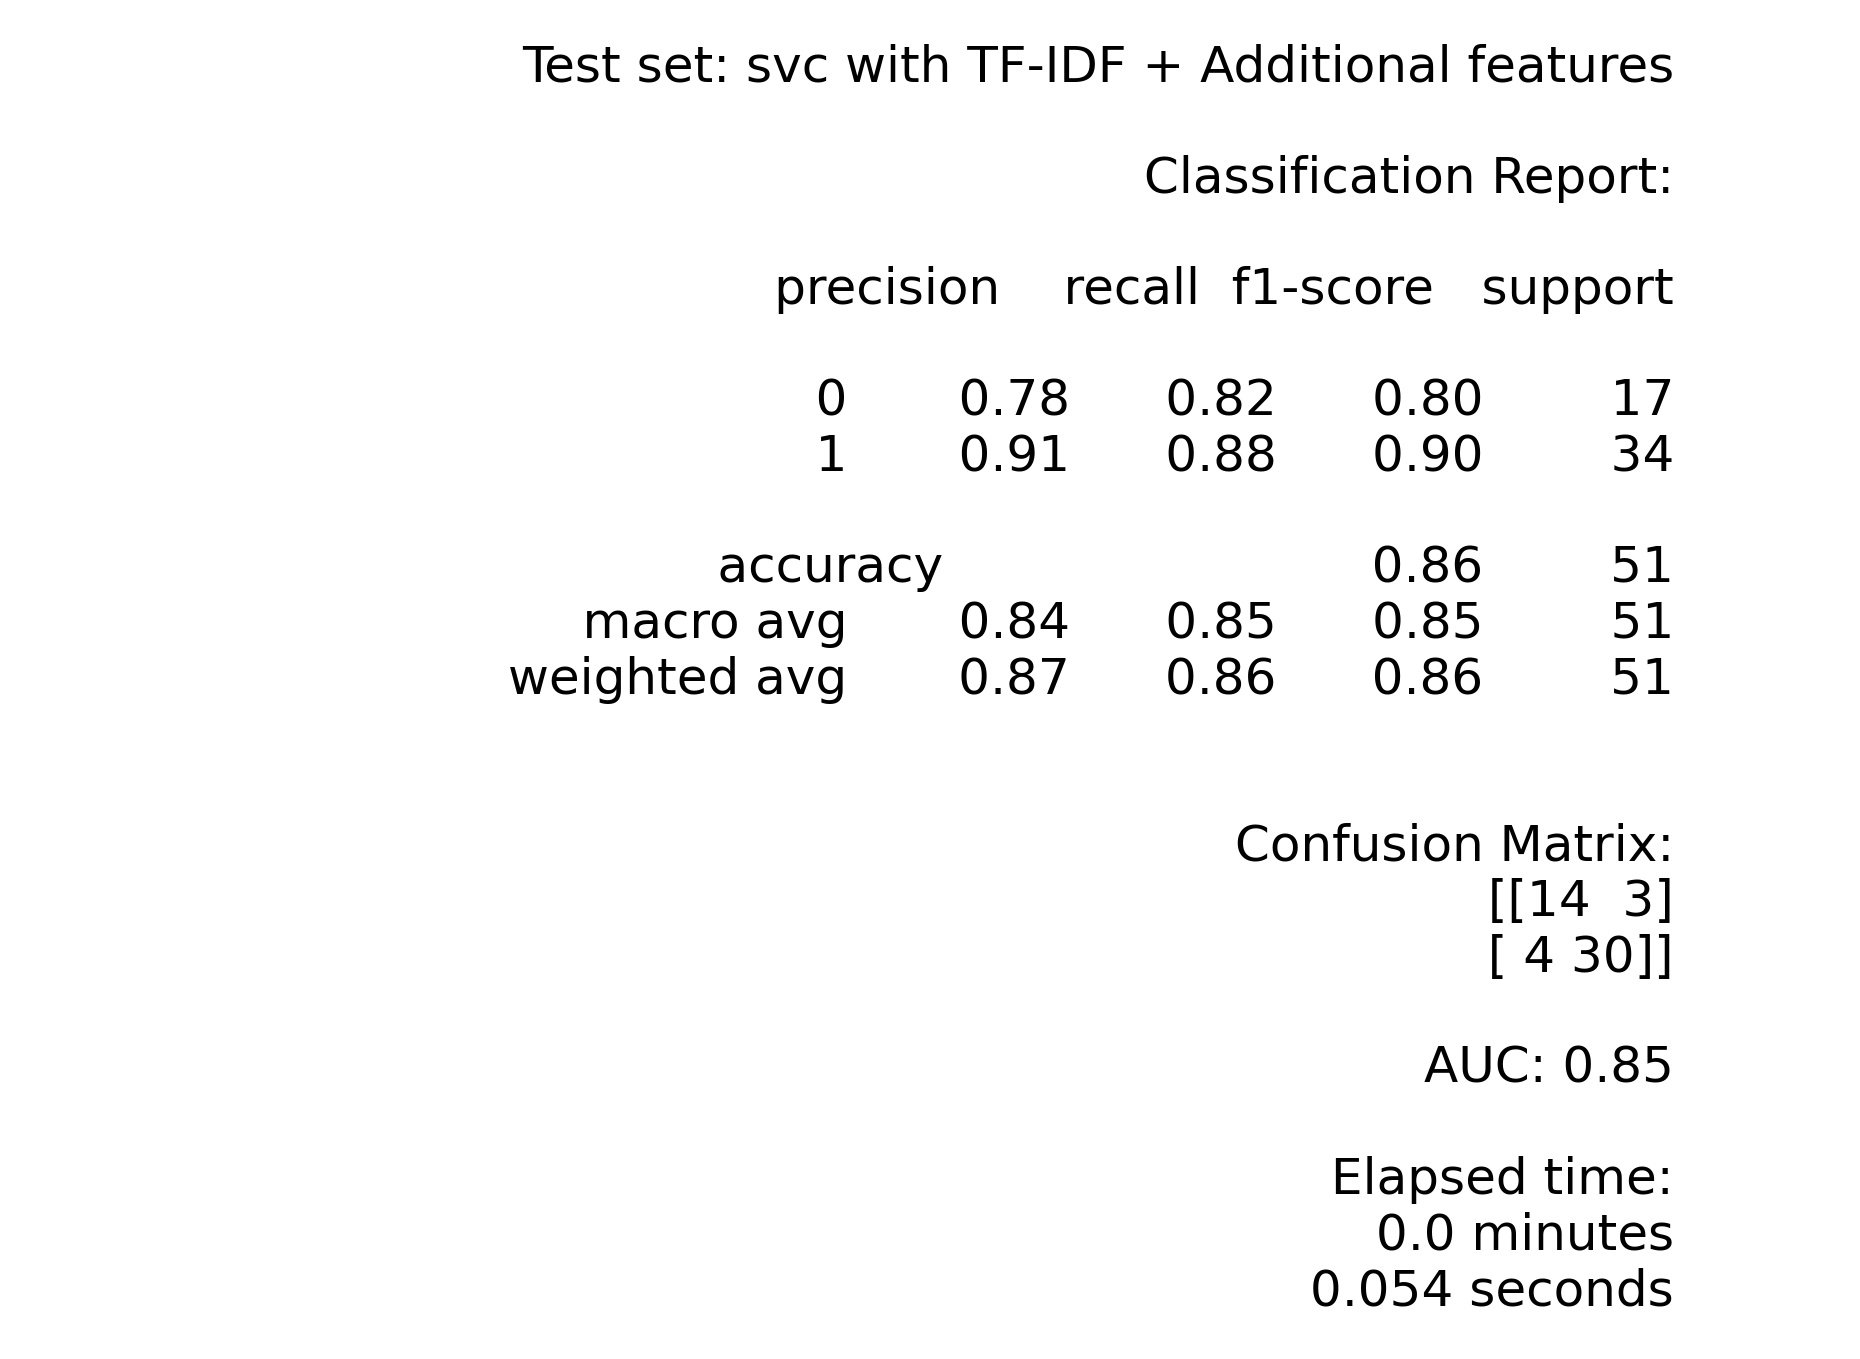

NEXT ARCHITECTURE


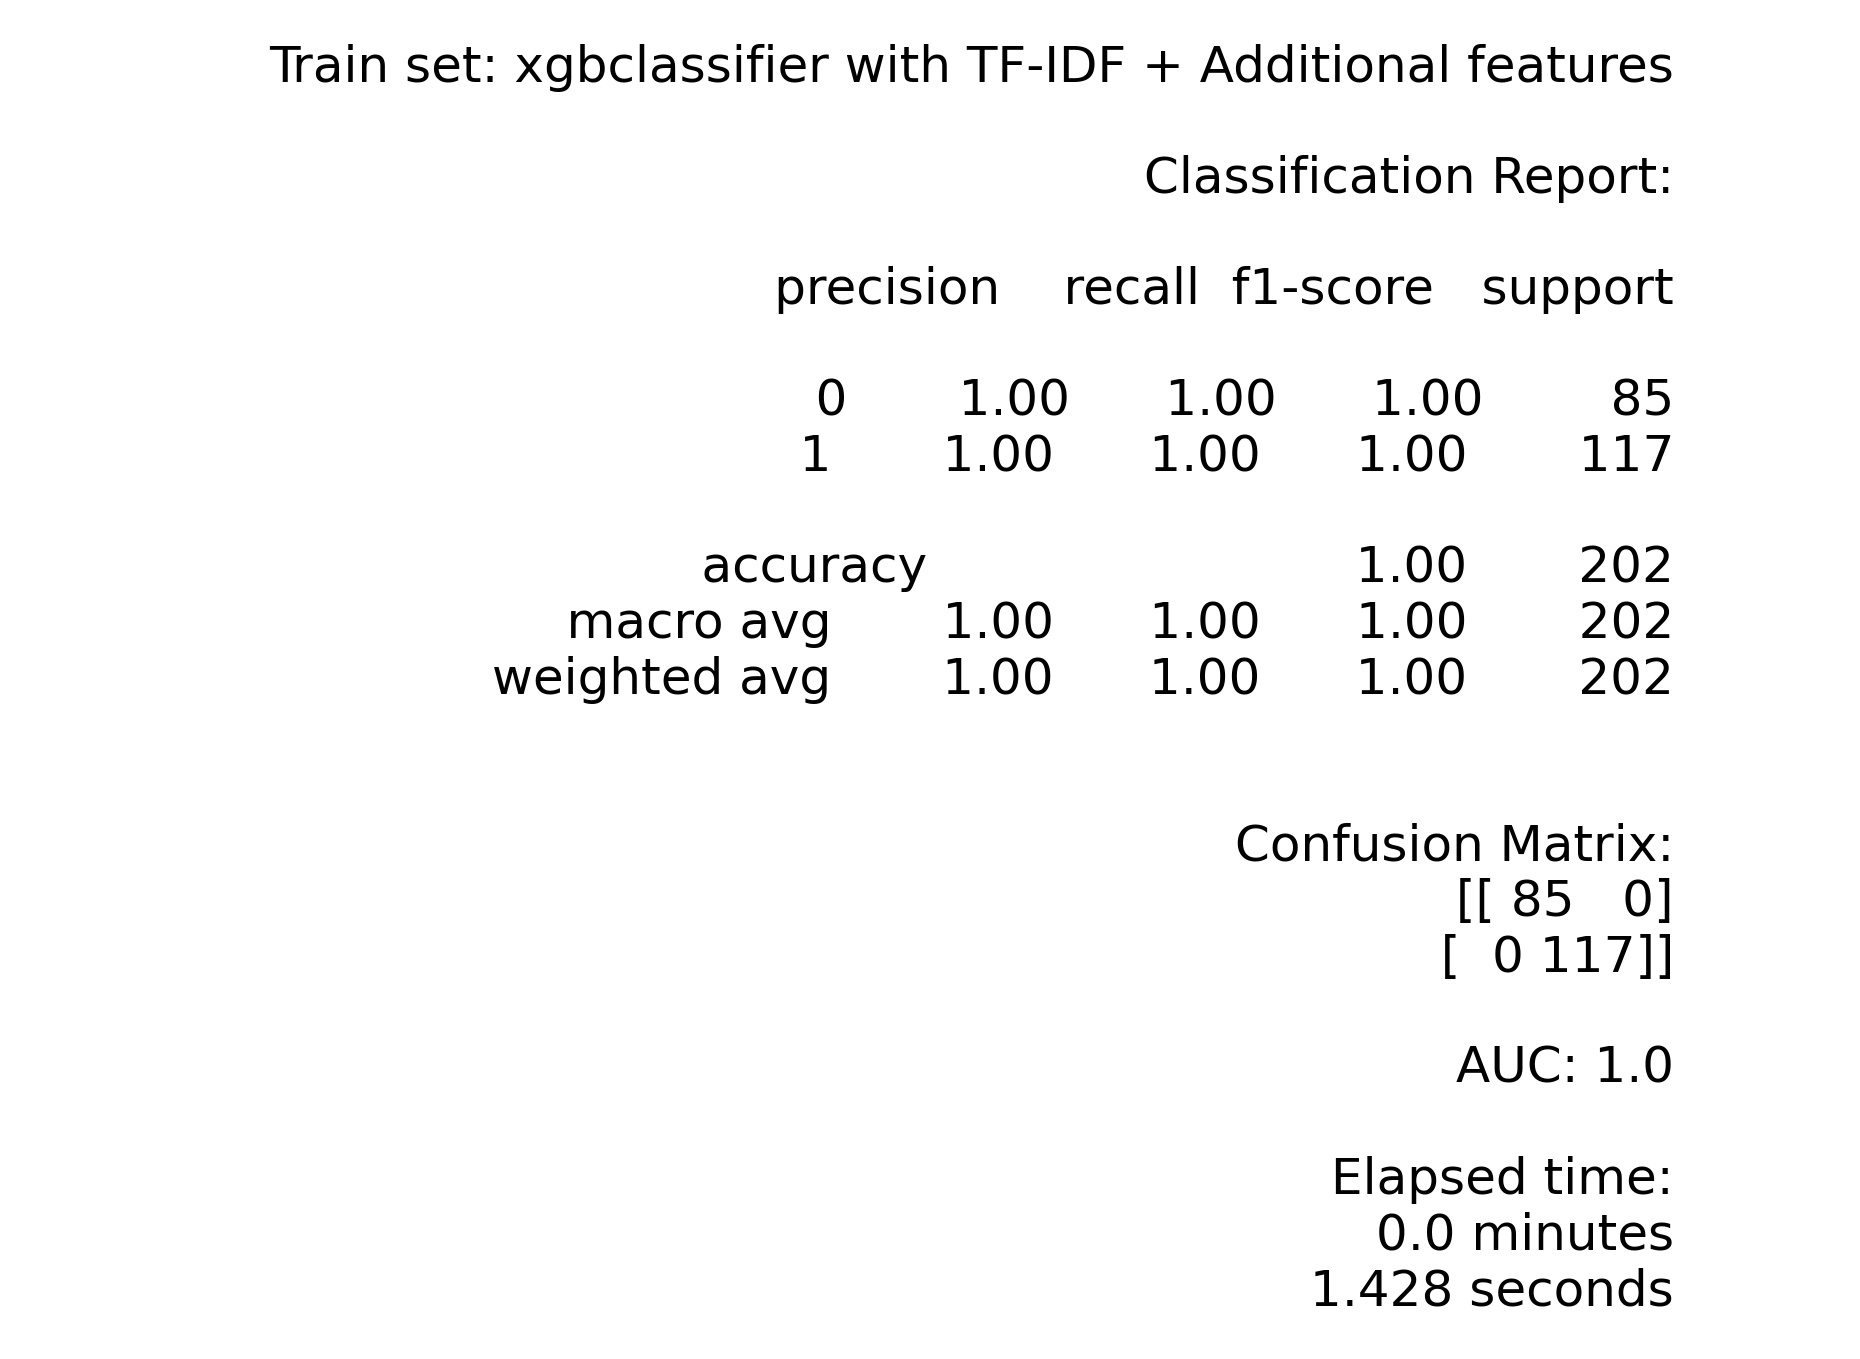

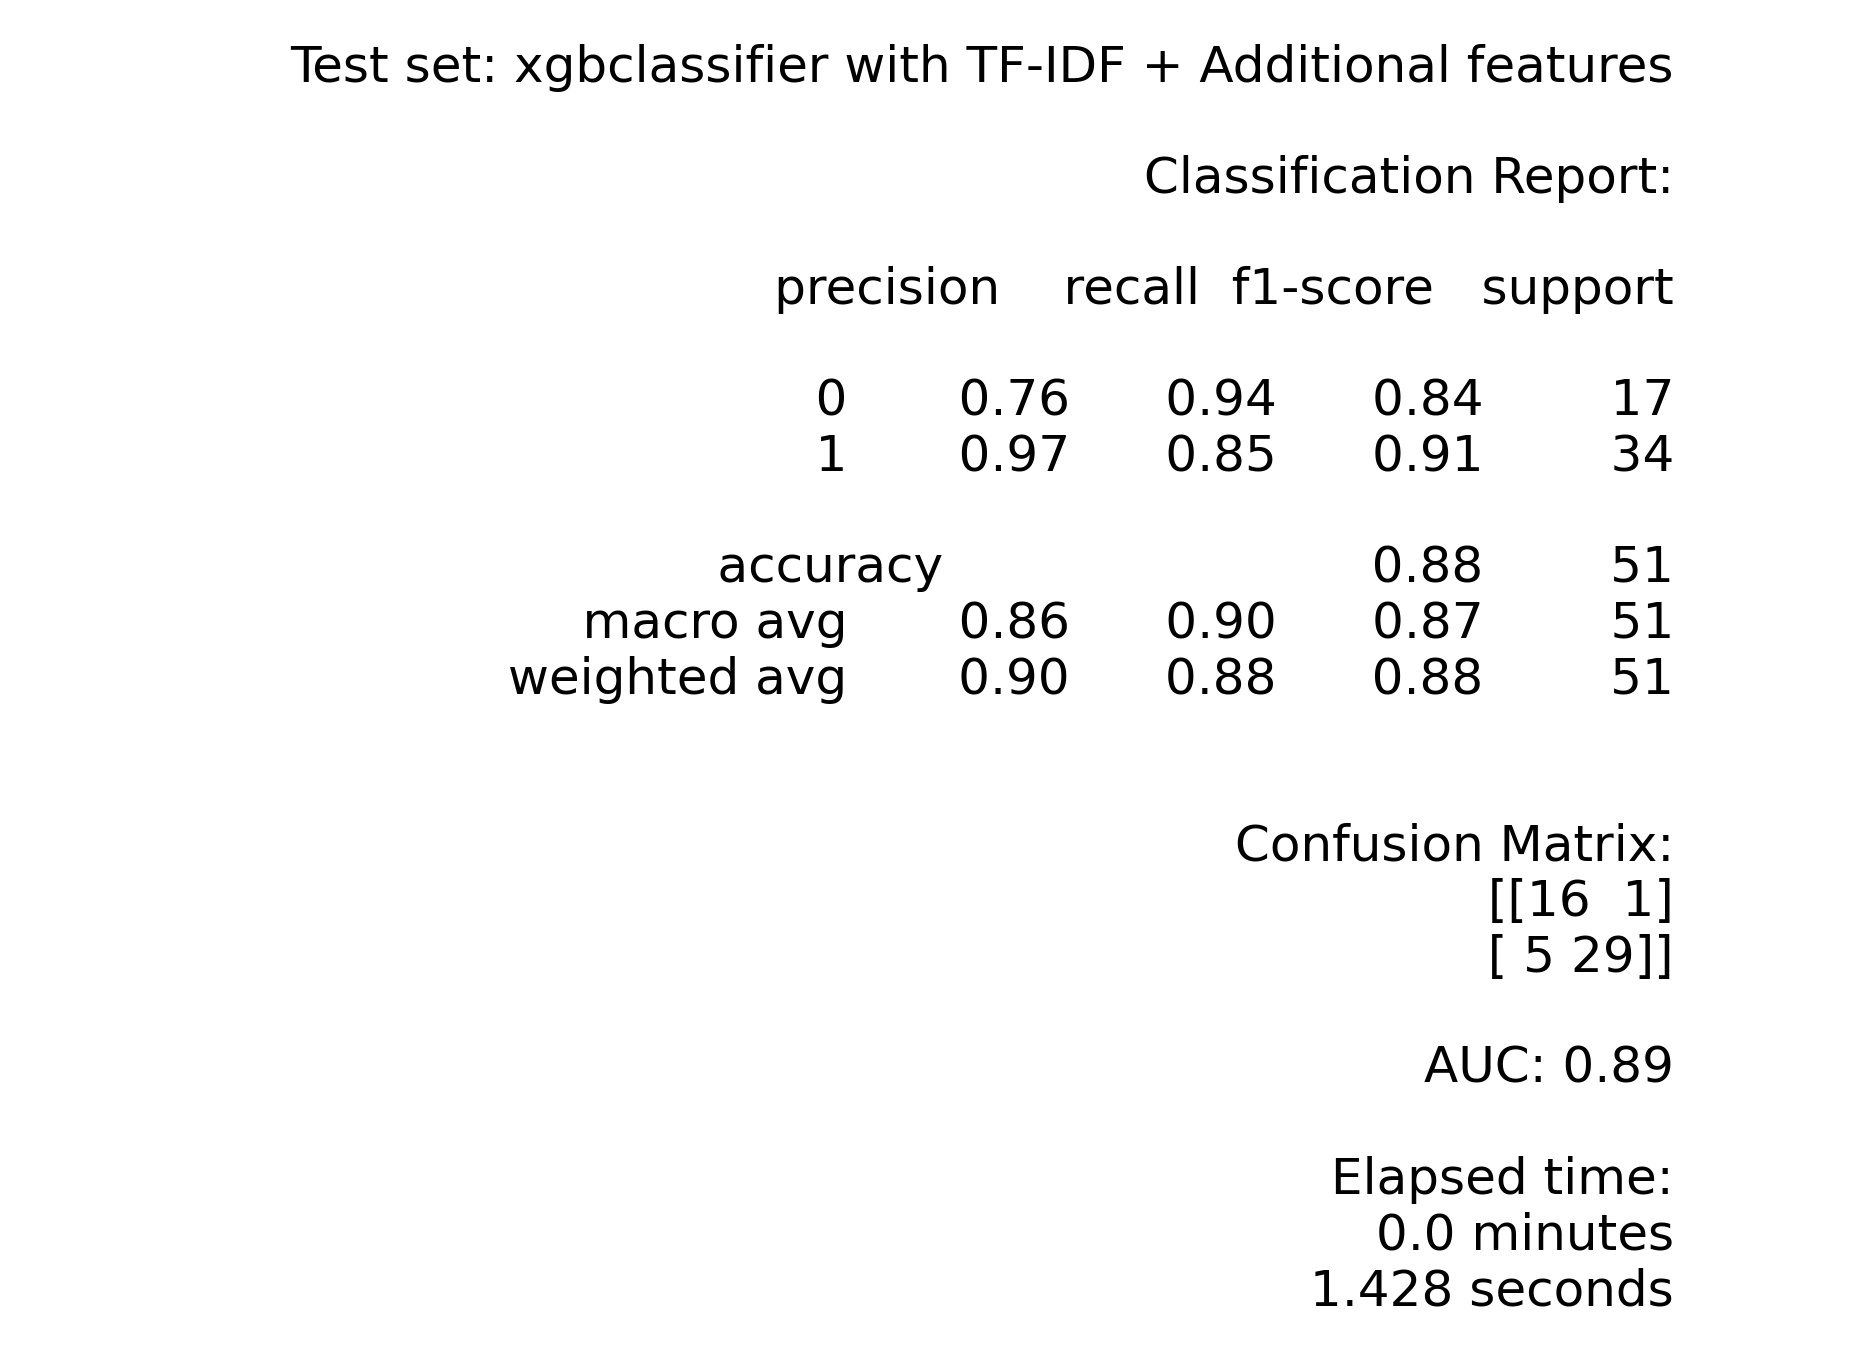

In [98]:
# Suppress ConvergenceWarnings from scikit-learn
warnings.filterwarnings("ignore", category=Warning)

# Example usage:
# Define hyperparameters for the chosen model
logreg_hyperparameters = {
    "logisticregression__C": [0.1, 1, 5],
    # Add hyperparameters for other models as needed
}

# Define hyperparameters for SVC
svc_hyperparameters = {
    "svc__C": [0.1, 1],  # Adjust the C values as needed
    "svc__kernel": ["rbf"],  # , 'linear'],  # Adjust the kernel choices as needed
}

# Define hyperparameters for XGBClassifier
xgb_hyperparameters = {
    "xgbclassifier__learning_rate": [
        0.01,
        0.1,
        0.3,
    ],  # Adjust the learning rates as needed
    "xgbclassifier__max_depth": [3, 4, 5],  # Adjust the max_depth values as needed
    # Add other hyperparameters for XGBClassifier as needed
}

# Call the function to train and evaluate the LogReg model
trained_model = train_and_evaluate_model(
    "logisticregression", logreg_hyperparameters, train_X, train_y, test_X, test_y
)
print("NEXT ARCHITECTURE")
# Call the function to train and evaluate the SVC model
trained_svc_model = train_and_evaluate_model(
    "svc", svc_hyperparameters, train_X, train_y, test_X, test_y
)
print("NEXT ARCHITECTURE")
# Call the function to train and evaluate the XGBClassifier model
trained_xgb_model = train_and_evaluate_model(
    "xgbclassifier", xgb_hyperparameters, train_X, train_y, test_X, test_y
)

## Conclusion:

The dataset provided to us is quite small, and while data oversampling might be an option for larger datasets, it won't significantly impact the results in this case. Our goal is to create an efficient solution capable of running on lower-tier machines, possibly even on devices like a Raspberry Pi. To maintain efficiency and keep the computational complexity (Big O notation) manageable, we prefer to work with the smaller dataset.

During the exploratory data analysis (EDA) phase, we observed that simple models like logistic regression and Support Vector Classifier (SVC) performed well in making predictions. However, XGBoost consistently outperformed the other models. It's worth noting that this conclusion is based on a small dataset. If we were to use a larger dataset, the performance gap between the simpler models and the boosting algorithm might become even more pronounced.

For reference, we have generated images containing metrics, which can be found in the "./EDA" folder. This notebook is compatible with both Jupyter and Colaboratory environments.